# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath = "/content/drive/Shareddrives/CSOC20010_Final_Project"

Mounted at /content/drive


In [ ]:
import requests
import networkx as nx
import pandas as pd


#Source for this part of the code (edited): https://public.paws.wmcloud.org/47923684/Lab%202.ipynb

S = requests.Session()

def get_page_outlinks(page_title, redirects=0):
  url = "https://en.wikipedia.org/w/api.php"

  params = {
      "action": "query",
      "format": "json",
      "list": "backlinks",
      "bltitle": page_title,
      "bllimit": "250",
      "blnamespace": "0",
      "redirects": redirects,
      "blredirects": redirects
  }

  R = S.get(url=url, params=params)
  data = R.json()

  try:
    blcontinue = data["continue"]["blcontinue"]
    backlinks = data["query"]["backlinks"]
    continue_search = data["continue"]["continue"]
  except KeyError:
    backlinks = data["query"]["backlinks"]
    continue_search = None

  back_links = []

  for b in backlinks:
      back_links.append(b["title"])

  while continue_search != None:
    try:
      params = {
        "action": "query",
        "format": "json",
        "list": "backlinks",
        "continue": continue_search,
        "bltitle": "COVID-19",
        "bllimit": "250",
        "blnamespace": "0",
        "blcontinue": blcontinue,
        "redirects": redirects,
        "blredirect": redirects
      }
      R = S.get(url=url, params=params)
      data = R.json()
      backlinks = data["query"]["backlinks"]
      for b in backlinks:
        back_links.append(b["title"])
      blcontinue = data["continue"]["blcontinue"]
      continue_search = data["continue"]["continue"]
    except KeyError:
      break
  return back_links

  

def get_hyperlink_alters(seed_page):
    # Initialize an empty dictionary to act as an adjacency "list"
    neighbors = {}
    
    # Get all the alters for the seed page and store them in the adjacency dictionary
    neighbors[seed_page] = get_page_outlinks(seed_page,1)
    
    # For each of the alters, get their alters and store in the adjacency dictionary
    for neighbor in list(set(neighbors[seed_page])): # Don't recrawl duplicates
        neighbors[neighbor] = get_page_outlinks(neighbor,0)
    
    # Initialize an empty graph that we will add nodes and edges into
    g = nx.DiGraph()
    
    # For each entry in the adjacency dictionary, check if the alter's alters are also the seed page's alters
    # If they are and the edge is already in the graph, increment the edge weight by one
    # If they are but the edge is not already in the graph, add the edge with a weight of one
    for article,neighbor_list in neighbors.items():
        for neighbor in neighbor_list:
            if neighbor in neighbors[seed_page] + [seed_page]:
                if g.has_edge(article,neighbor):
                    g[article][neighbor]['weight'] += 1
                else:
                    g.add_edge(article,neighbor,weight=1)
    
    # Return the weighted graph
    return g

# Get links and create network

In [ ]:
import pandas as pd
links = pd.read_csv("/content/drive/Shareddrives/CSOC20010_Final_Project/data/1. FIRST-DEGREE-BACKLINKS-WITH-IDS-quarry-62754-select-page-linking-to-covid-19-run625929.csv")
links = links.drop(['page_id'], axis=1)
links = links.page_title.to_list()

In [ ]:
cats_graph = nx.read_adjlist("/content/drive/Shareddrives/CSOC20010_Final_Project/data/cats_adjacency_list.csv", delimiter=",")

# Get categories of articles

In [ ]:
category_page_titles = ["Category-Class_geography_articles", "List-Class_history_articles", "Human_activities", \
                        "Society", "Mathematics", "Nature", "People", "Start-Class_Philosophy_articles", \
                        "_technology", "Vital_articles/Level/5/Biological_and_health_sciences/Health"]
#Reference, Religion, and Culture missing because they dissapeared from graph


def category_readable(category):
    cat_names = {"Category-Class_geography_articles": "Geography", "List-Class_history_articles": "History", \
    "Human_activities": "Human activities", "Society": "Society", "Mathematics": "Mathematics", "Nature": "Nature", \
    "People": "People", "Start-Class_Philosophy_articles":"Philosophy", "_technology": "Technology", \
    "Vital_articles/Level/5/Biological_and_health_sciences/Health": "Health", "Uncategorized": "Uncategorized"}
    return(cat_names[category])

#Gets an article's category based on shortest path
def get_category(article):
    path_lengths = {}
    try:
      for category in category_page_titles:
        try:
          path_length = len(nx.shortest_path(cats_graph, article, category))
        except nx.NetworkXNoPath:
          #NodeNotFound is source node
          path_length = 1000
        path_lengths[category] = path_length
      category = min(path_lengths, key=path_lengths.get)
    except nx.NodeNotFound:
      category = "Uncategorized"
    return(category_readable(category))

#***If there is a tie, it returns whichever comes first in the dictionary. We may want to fix this depending on how common ties are***

In [ ]:
#For loop that tallies articles per category

categories = {"Geography": 0, "History": 0, "Human activities": 0, "Society": 0, "Mathematics": 0, "Nature": 0, \
     "People": 0, "Philosophy": 0, "Technology": 0, "Health": 0, "Uncategorized": 0, "Religion": 0, "Reference": 0, "Culture": 0}

for article in links:
    category = get_category(article)
    categories[category] += 1

# Graph

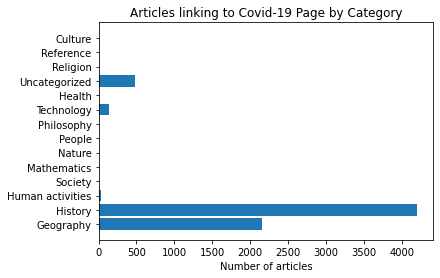

In [ ]:
import matplotlib.pyplot as plt
plt.barh(list(categories.keys()), list(categories.values()))
plt.xlabel('Number of articles')
plt.title('Articles linking to Covid-19 Page by Category')
plt.savefig("/content/drive/Shareddrives/CSOC20010_Final_Project/category_distribution.png", dpi=300, \
            bbox_inches = "tight")

In [ ]:
print(categories)

{'Geography': 2151, 'History': 4208, 'Human activities': 31, 'Society': 2, 'Mathematics': 0, 'Nature': 0, 'People': 0, 'Philosophy': 2, 'Technology': 141, 'Health': 1, 'Uncategorized': 486, 'Religion': 0, 'Reference': 0, 'Culture': 0}


## What might have gone wrong:

* We got the first-neighbour backlinks from the live database, while we got the categorylinks from the backup page, and in accounting for this some backlnk page data may have been lost during the data cleaning phase

* Could also be a junk page which we did not remove. (Lots of pages may link to history/geography via a maintenance page which was not removed in the data cleanup)

* We used a random subset of the data which made up approximately 30% of all first neighbour nodes, which may have been biased towards history or geography.

* There is a chance that most of the articles in our subset are in some way about history or geography.

## How would we improve

* More RAM.

* Use data from the same time period

* Use the entire dataset rather than a random subset to better show the distribution of categories.

* Check if the distribution of an article categories in all articles related to COVID-19 mirrors the distribution of article categories across Wikipedia